FastAI Image Classification: https://towardsdatascience.com/fastai-image-classification-32d626da20

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls '/content/drive/My Drive/Colab Notebooks/dataset.zip'

'/content/drive/My Drive/Colab Notebooks/dataset.zip'


In [0]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/dataset.zip", 'r')
zip_ref.extractall("/content/data")
zip_ref.close()

In [0]:
#create directory and move datatset files to it
!mkdir "/content/data/manual"
!mkdir "/content/data/manual/chexpert"
!mv "/content/data/CheXpert-v1.0-small/CheXpert-v1.0-small" "/content/data/manual/chexpert"
!ls "/content/data/manual/chexpert/CheXpert-v1.0-small"

train  train.csv  valid  valid.csv


In [0]:
import pandas as pd
import glob

path = r'/content/data/manual/chexpert/CheXpert-v1.0-small'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
  df = pd.read_csv(filename, index_col=None, header=0)
  li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223643,CheXpert-v1.0-small/valid/patient64736/study1/...,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223644,CheXpert-v1.0-small/valid/patient64737/study1/...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223645,CheXpert-v1.0-small/valid/patient64738/study1/...,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223646,CheXpert-v1.0-small/valid/patient64739/study1/...,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
frame.iloc[:,0]

0         CheXpert-v1.0-small/train/patient00001/study1/...
1         CheXpert-v1.0-small/train/patient00002/study2/...
2         CheXpert-v1.0-small/train/patient00002/study1/...
3         CheXpert-v1.0-small/train/patient00002/study1/...
4         CheXpert-v1.0-small/train/patient00003/study1/...
                                ...                        
223643    CheXpert-v1.0-small/valid/patient64736/study1/...
223644    CheXpert-v1.0-small/valid/patient64737/study1/...
223645    CheXpert-v1.0-small/valid/patient64738/study1/...
223646    CheXpert-v1.0-small/valid/patient64739/study1/...
223647    CheXpert-v1.0-small/valid/patient64740/study1/...
Name: Path, Length: 223648, dtype: object

In [0]:
frame.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [0]:
import numpy as np

images = np.memmap('memmap.dat', mode='w+', shape=(223648, 299, 299, 3), dtype=np.uint8)

In [0]:
labels = frame[['Pleural Effusion']]
# lung opacity, edema, pleural effusion

In [0]:
labels.isna().sum()

Pleural Effusion    90203
dtype: int64

In [0]:
print(len(images))
print(len(labels))

223648
223648


In [0]:
frame['Pleural Effusion'].unique()

array([nan, -1.,  0.,  1.])

In [0]:
from fastai.vision import *

In [0]:
from fastai.metrics import error_rate # 1 - accuracy

np.random.seed(42)
# from_folder(path:PathOrStr, train:PathOrStr='train', valid:PathOrStr='valid')
data = ImageDataBunch.from_folder(path=r'/content/data/manual/chexpert/CheXpert-v1.0-small/',
                                  # im guessing the issue is setting train=frame (the entire dataframe)
                                  # train should be in the form:
                                    # label 1 (for example, 'cat')
                                      # all images of cats
                                    # label 2 (for example, 'dog')
                                      # all images of dogs
                                  # etc
                                  train=frame, valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)

# should 'data' be 'dset' or 'dataset' from above?
learn = create_cnn(data, models.resnet34, metrics=error_rate)

# should 'data' be 'dset' or 'dataset'?
#learn = cnn_learner(frame, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 28.9MB/s]


In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.249919,2.202487,0.629547,43:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


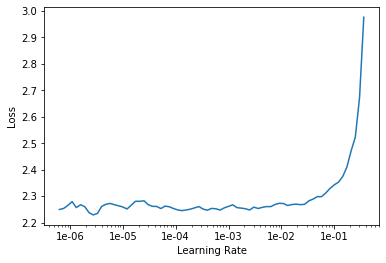

In [0]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()